# Introduction

This model was built based on a Keras (Chollet, F. & others, 2015. Keras. Available at: https://github.com/fchollet/keras.) demonstration on how to classify speakers using Fast Fourier Transform (FFT) and a 1D convolutional neural network model audio classification.

It shows the following:

How to use tf.data to load, preprocess and feed audio streams into a model
How to create a 1D convolutional network with residual connections for audio classification.

Our process:

We prepare a dataset of speech samples from different speakers, with the speaker as label.
We add background noise to these samples to augment our data.
We take the FFT of these samples.
We train a 1D convnet to predict the correct speaker given a noisy FFT speech sample.

Note:

The noise samples in the dataset were standardized to a sampling rate of 16000 Hz before using the code in this example. In order to do this, we resampled using audacity.

Chollet, F. & others, 2015. Keras. Available at: https://github.com/fchollet/keras.

Background sounds taken from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/download

In [14]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras
import pydot
import matplotlib

from pathlib import Path
from IPython.display import display, Audio

# The database was built using 7 minute of speach from each member of the group
DATASET_ROOT = os.path.join(os.path.expanduser("~"), "Documents/AI - Math II/voice-classifier/Data")

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100

# Data preparation

### The dataset is composed of 7 folders, divided into 2 groups:

- Speech samples, with 5 folders, one for each member in our group. Each folder contains audio files for that speaker, each 1 second long and sampled at 16000 Hz.
- Background noise samples, with 2 folders and a total of 6 files. These files are longer than 1 second (and originally not sampled at 16000 Hz, but we will resample them to 16000 Hz). We will use those 6 files to create 354 1-second-long noise samples to be used for training.

### Let's sort these 2 categories into 2 folders:

- An audio folder which will contain all the per-speaker speech sample folders
- A noise folder which will contain all the noise samples

Before sorting the audio and noise categories into 2 folders,

main_directory/

    ...speaker_juan/
    ...speaker_hom/
    ...speaker_mike/
    ...speaker_ed/
    ...speaker_dan/
    ...other/
    ..._background_noise_/

After sorting, we end up with the following structure:
    
main_directory/

    ...audio/
    ......speaker_juan/
    ......speaker_hom/
    ......speaker_mike/
    ......speaker_ed/
    ......speaker_dan/
    ...noise/
    ......other/
    ......_background_noise_/

In [3]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

# Noise preparation
In this section:

- We load all noise samples (which should have been resampled to 16000)
- We split those noise samples to chuncks of 16000 samples which correspond to 1 second duration each

In [4]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


Resample all noise samples to 16000 Hz

In [5]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

os.system(command)

# Split noise into chunks of 16000 each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


# Dataset generation

In [6]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Daniel', 'Ed', 'Hom', 'Juan', 'Mike', 'test']
Processing speaker Daniel
Processing speaker Ed
Processing speaker Hom
Processing speaker Juan
Processing speaker Mike
Processing speaker test
Found 1983 files belonging to 6 classes.
Using 1785 files for training.
Using 198 files for validation.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


# Model Definition

In [7]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8000, 16)     64          input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 8000, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8000, 16)     784         activation[0][0]                 
______________________________________________________________________________________________

# Training

In [8]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
14/14 [==============================] - 7s 195ms/step - loss: 1.8069 - accuracy: 0.3008 - val_loss: 1.1684 - val_accuracy: 0.6364


C:\Users\Mike\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
14/14 [==============================] - 2s 113ms/step - loss: 0.8517 - accuracy: 0.6992 - val_loss: 0.6714 - val_accuracy: 0.7374
Epoch 3/100
14/14 [==============================] - 2s 110ms/step - loss: 0.5303 - accuracy: 0.8275 - val_loss: 0.4439 - val_accuracy: 0.8434
Epoch 4/100
14/14 [==============================] - 2s 111ms/step - loss: 0.4444 - accuracy: 0.8504 - val_loss: 0.4034 - val_accuracy: 0.8535
Epoch 5/100
14/14 [==============================] - 2s 112ms/step - loss: 0.3761 - accuracy: 0.8863 - val_loss: 0.2768 - val_accuracy: 0.9141
Epoch 6/100
14/14 [==============================] - 2s 111ms/step - loss: 0.3267 - accuracy: 0.8975 - val_loss: 0.2648 - val_accuracy: 0.9192
Epoch 7/100
14/14 [==============================] - 2s 110ms/step - loss: 0.2762 - accuracy: 0.9165 - val_loss: 0.1764 - val_accuracy: 0.9343
Epoch 8/100
14/14 [==============================] - 2s 111ms/step - loss: 0.2960 - accuracy: 0.9081 - val_loss: 0.2065 - val_accuracy: 0.9343

# Evaluation

In [9]:
print(model.evaluate(valid_ds))

7/7 [==============================] - 1s 24ms/step - loss: 0.0302 - accuracy: 0.9899
[0.03020814061164856, 0.9898989796638489]


In [10]:
_, accuracy = model.evaluate(valid_ds)
print('Accuracy: %.1f' % (accuracy*100))

7/7 [==============================] - 0s 39ms/step - loss: 0.0302 - accuracy: 0.9899
Accuracy: 99.0


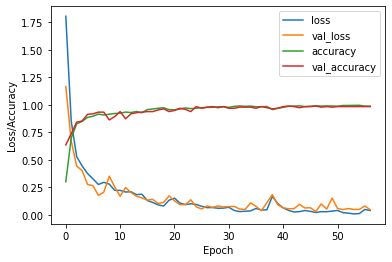

In [15]:
# plot training history
%matplotlib inline 
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.legend()
#plt.title('model accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss/Accuracy')
pyplot.show()

# Demonstration
Let's take some samples and:

- Predict the speaker
- Compare the prediction with the real speaker
- Listen to the audio to see that despite the samples being noisy, the model is still pretty accurate

In [16]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker: {} - Predicted: {}".format(
                class_names[labels[index]],
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

Speaker: Ed - Predicted: Ed


Speaker: Daniel - Predicted: Daniel


Speaker: Ed - Predicted: Ed


Speaker: Ed - Predicted: Ed


Speaker: Mike - Predicted: Mike


Speaker: Ed - Predicted: Ed


Speaker: Juan - Predicted: Juan


Speaker: Ed - Predicted: Ed


Speaker: Hom - Predicted: Hom


Speaker: Juan - Predicted: Juan


In [ ]:
model.save("Speaker_Recognition_Model")

In [ ]:
model = keras.models.load_model("Speaker_Recognition_Model")

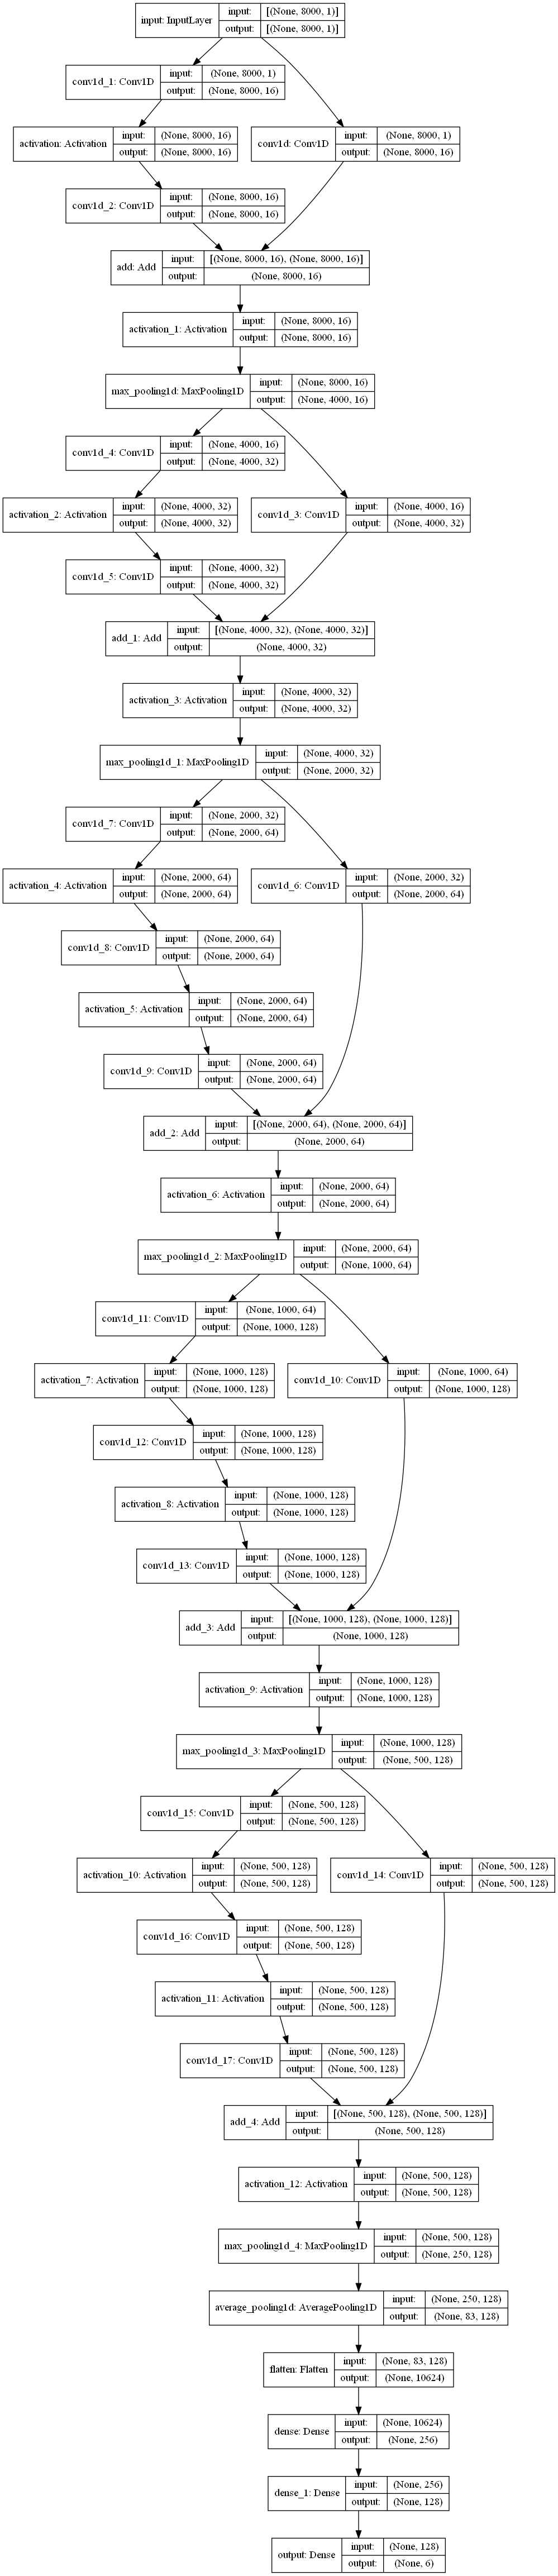

In [9]:
keras.utils.plot_model(model, show_shapes=True)